In [6]:
import os
import sys

if "COLAB_GPU" in os.environ:
  from google.colab import drive
  print("Hello, Colab")
  drive.mount("/content/drive")
  ROOT_PATH = "/content/drive/MyDrive/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
elif "PAPERSPACE_CLUSTER_ID" in os.environ:
  print("Hello, Paperspace")
  ROOT_PATH = "/notebooks/hero"
  os.environ["CLEARML_CONFIG_FILE"] = f"{ROOT_PATH}/clearml.conf"
else:
  ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))

EXPERIMENT_PATH = f"{ROOT_PATH}/experiments/tcnn-abilities"
ARTIFACTS_PATH = f"{EXPERIMENT_PATH}/artifacts"
sys.path.insert(0, ROOT_PATH)

In [7]:
from collections import defaultdict
from json import load, dumps, dump

from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from src.utils import get_logical_plan, get_full_plan, get_selectivities
from src.models import binary_tree_layers as btl
from src.datasets.oracle import Oracle, OracleRequest, TIMEOUT
from src.datasets.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from src.datasets.data_types import ExplainNode
from src.datasets.vectorization import extract_vertices_and_edges, ALL_FEATURES
from src.datasets.binary_tree_dataset import binary_tree_collate, BinaryTreeDataset, WeightedBinaryTreeDataset, weighted_binary_tree_collate

# Loading data

## Step 1. Preprocessing plans
Here we load from `Oracle` (for `JOB` and `SQ`) data with queries and their plans under different parameters and
then processing these plans to pairs `vertices`, `edges`.

In [4]:
def extract_list_info(oracle, query_names):
    """ Collects dicts with info 'query_name', 'hintset', 'dop', 'vertices', 'edges', 'time'"""
    list_info = []

    for query_name in tqdm(query_names, leave=False):
        seen_logical_plans = set()
        timeouted_logical_plans_to_dops = defaultdict(set)
        timeouted_logical_plans_to_settings = defaultdict(list)
        logical_plan_to_times = defaultdict(list)
        for dop in DOPS:            
            for hintset in HINTSETS:
                custom_request = OracleRequest(query_name=query_name, hintset=hintset,dop=dop)
                custom_logical_plan = get_logical_plan(query_name=query_name, oracle=oracle, hintset=hintset, dop=dop)
                custom_time = oracle.get_execution_time(custom_request)
                if custom_time != TIMEOUT:
                    info = {"query_name": query_name, "hintset": hintset, "dop": dop}
                    time = torch.tensor(custom_time / 1000, dtype=torch.float32)
                    vertices, edges = extract_vertices_and_edges(oracle.get_explain_plan(request=custom_request))
                    info.update({"time": time, "vertices": vertices, "edges": edges}) 
                    seen_logical_plans.add(custom_logical_plan)
                    list_info.append(info)
                    logical_plan_to_times[custom_logical_plan].append(time)
                else:
                    timeouted_logical_plans_to_dops[custom_logical_plan].add(dop)
                    timeouted_logical_plans_to_settings[custom_logical_plan].append((dop, hintset))

        for custom_logical_plan in timeouted_logical_plans_to_settings:             
            if custom_logical_plan in logical_plan_to_times:
                time = sum(logical_plan_to_times[custom_logical_plan]) / len(logical_plan_to_times[custom_logical_plan])
            else:
                max_def_time = 0
                for dop in timeouted_logical_plans_to_dops[custom_logical_plan]:
                    def_request = OracleRequest(query_name=query_name, hintset=0, dop=dop)
                    def_time = oracle.get_execution_time(request=def_request)
                    max_def_time = max(max_def_time, def_time)
                time = torch.tensor(2 * max_def_time / 1000, dtype=torch.float32)

            for dop, hintset in timeouted_logical_plans_to_settings[custom_logical_plan]:
                info = {"query_name": query_name, "hintset": hintset, "dop": dop}
                custom_request = OracleRequest(query_name=query_name, hintset=hintset, dop=dop)
                vertices, edges = extract_vertices_and_edges(oracle.get_explain_plan(request=custom_request))
                info.update({"time": time, "vertices": vertices, "edges": edges})             
                list_info.append(info)
            
    return list_info

In [5]:
job_oracle = Oracle(f"{ROOT_PATH}/data/processed/JOB")

job_list_info = extract_list_info(oracle=job_oracle, query_names=job_oracle.get_query_names())
job_list_vertices, job_list_edges, job_list_time = [[info[key] for info in job_list_info] for key in ["vertices", "edges", "time"]]

job_max_possible_size = len(job_oracle.get_query_names()) * len(DOPS) * len(HINTSETS)
print(f"[JOB]: dataset size is {len(job_list_info)} / {job_max_possible_size}")

[JOB]: dataset size is 43392 / 43392


In [6]:
sq_oracle = Oracle(f"{ROOT_PATH}/data/processed/sample_queries")

sq_list_info = extract_list_info(oracle=sq_oracle, query_names=sq_oracle.get_query_names())
sq_list_vertices, sq_list_edges, sq_list_time = [[info[key] for info in sq_list_info] for key in ["vertices", "edges", "time"]]

sq_max_possible_size = len(sq_oracle.get_query_names()) * len(DOPS) * len(HINTSETS)
print(f"[SQ]: dataset size is {len(sq_list_info)} / {sq_max_possible_size}")

[SQ]: dataset size is 15360 / 15360


In [7]:
job_X = set([(str(v.flatten().tolist()), str(e.flatten().tolist())) for v, e in zip(job_list_vertices, job_list_edges)])
sq_X = set([(str(v.flatten().tolist()), str(e.flatten().tolist())) for v, e in zip(sq_list_vertices, sq_list_edges)])
print(f"Around {100 * len(sq_X & job_X) / len(sq_X):0.1f} % of plans from SQ bench exists in JOB bench")

Around 23.0 % of plans from SQ bench exists in JOB bench


## Step 2. Splitting data to train-val / test sets

Since the queries from `SQ` are also over `imdb` data, we can use them as a *test* dataset. However, some of them are very different in nature from queries from `JOB`, so we will create two versions of the test dataset - **in-distrubtion** and **out-of-distribution** versions. 
We will consider a query $q$ as a in-distribution (`id` query) if its default logical tree occurs among the default logical trees of `JOB`s queries, otherwise we will call it a out-of-distribution (`ood`) query.

In [8]:
job_logical_plans = set(
    get_logical_plan(oracle=job_oracle,  query_name=query_name, hintset=hintset, dop=dop)
    for query_name in job_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
)

ood_sq_list_info, id_sq_list_info = [], []
for info in sq_list_info:
    logical_plan = get_logical_plan(oracle=sq_oracle, query_name=info["query_name"], hintset=info["hintset"], dop=info["dop"])
    if logical_plan not in job_logical_plans:
        ood_sq_list_info.append(info)
    else:
        id_sq_list_info.append(info)
        
ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time = [[info[key] for info in ood_sq_list_info] for key in ["vertices", "edges", "time"]]
id_sq_list_vertices, id_sq_list_edges, id_sq_list_time = [[info[key] for info in id_sq_list_info] for key in ["vertices", "edges", "time"]]
assert len(ood_sq_list_info) + len(id_sq_list_info) == len(sq_list_info), "Something went wrong ..."

In other notebooks we will need information about queries corresponding to `vertices` and `edges`, so we have to save lists

In [9]:
# torch.save(job_list_info, f"{ARTIFACTS_PATH}/job_list_info")
# torch.save(ood_sq_list_info, f"{ARTIFACTS_PATH}/ood_sq_list_info")
# torch.save(id_sq_list_info, f"{ARTIFACTS_PATH}/id_sq_list_info")

## Step 3. Creating `torch.Dataset`s

We see that most of the plans are repetitive. This is the reason for switching to **weighted** datasets (and dataloaders) to speed up the learning process.\
It also simplifies the landscape, leaving the solving of collision problem to the preprocessing stage.

In [10]:
job_all_plans = [
    get_full_plan(oracle=job_oracle, query_name=query_name, hintset=hintset, dop=dop)
    for query_name in job_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
]
print(f"[JOB]: total # of unique plans: {len(set(job_all_plans))} / {len(job_all_plans)}")

[JOB]: total # of unique plans: 7429 / 43392


In [11]:
sq_all_plans = [
    get_full_plan(oracle=sq_oracle, query_name=query_name, hintset=hintset, dop=dop)
    for query_name in sq_oracle.get_query_names() for hintset in HINTSETS for dop in DOPS
]
print(f"[SQ]: total # of unique plans: {len(set(sq_all_plans))} / {len(sq_all_plans)}")

[SQ]: total # of unique plans: 4496 / 15360


In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {DEVICE}")

device is cuda


In [13]:
job_dataset = BinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)
job_weighted_dataset = WeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE)
print(f"[JOB]: total # of unique plans in the weighted dataset {len(job_weighted_dataset)}")

[JOB]: total # of unique plans in the weighted dataset 7323


In [14]:
ood_sq_dataset = BinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE)
ood_sq_weighted_dataset = WeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE)
print(f"[SQ, OOD]: total # of unique plans in the weighted dataset {len(ood_sq_weighted_dataset)}")

id_sq_dataset = BinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
id_sq_weighted_dataset = WeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE)
print(f"[SQ, ID]: total # of unique plans in the weighted dataset {len(id_sq_weighted_dataset)}")

[SQ, OOD]: total # of unique plans in the weighted dataset 3409
[SQ, ID]: total # of unique plans in the weighted dataset 1021


# Baselines

Here we evaluate the worst and best possible predictors to know what we should aim for.

In [ ]:
def calculate_mse_for_best_constant_predictor(dataset):
    time_sum = 0
    count = 0

    for v, e, t in dataset:
        time_sum += t
        count += 1

    mse_loss = 0
    for v, e, t in dataset:
        t_pred = time_sum / count
        mse_loss += (t_pred - t) ** 2

    return mse_loss.item() / len(dataset)

In [ ]:
def calculate_mse_for_best_possible_predictor(dataset):
    sum_dict = defaultdict(float)
    count_dict = defaultdict(int)

    for v, e, t in dataset:
        key = str(v.flatten().tolist()), str(e.flatten().tolist())
        sum_dict[key] += t.item()
        count_dict[key] += 1

    mse_loss = 0
    for v, e, t in dataset:
        key = str(v.flatten().tolist()), str(e.flatten().tolist())
        t_pred = sum_dict[key] / count_dict[key]
        mse_loss += (t_pred - t) ** 2

    return mse_loss/ len(dataset)

In [ ]:
print(f"[JOB]: MSE of the best constant predictor is {calculate_mse_for_best_constant_predictor(job_dataset):0.3f}")
print(f"[JOB]: MSE of the best possible predictor is {calculate_mse_for_best_possible_predictor(job_dataset):0.3f}")

[JOB]: MSE of the best constant predictor is 135.607
[JOB]: MSE of the best possible predictor is 0.662


**O**ut **O**f **D**istribution vs **I**n **D**istribution

In [ ]:
print(f"[SQ, OOD]: MSE of the best constant predictor is {calculate_mse_for_best_constant_predictor(ood_sq_dataset):0.3f}")
print(f"[SQ, OOD]: MSE of the best possible predictor is {calculate_mse_for_best_possible_predictor(ood_sq_dataset):0.3f}")

print(f"[SQ, ID]: MSE of the best constant predictor is {calculate_mse_for_best_constant_predictor(id_sq_dataset):0.3f}")
print(f"[SQ, ID]: MSE of the best possible predictor is {calculate_mse_for_best_possible_predictor(id_sq_dataset):0.3f}")

[SQ, OOD]: MSE of the best constant predictor is 3953.941
[SQ, OOD]: MSE of the best possible predictor is 0.036
[SQ, ID]: MSE of the best constant predictor is 650.152
[SQ, ID]: MSE of the best possible predictor is 0.105


# Architectures

Here we set up some grid of architectures to be searched.

In [17]:
in_channels = len(ALL_FEATURES)

In [18]:
class BinaryTreeRegressor(nn.Module):
    def __init__(self, btcnn: "btl.BinaryTreeSequential", fcnn: "torch.nn.Sequential", name: "str" = "unknown"):
        super().__init__()
        self.btcnn: "btl.BinaryTreeSequential" = btcnn
        self.fcnn: "torch.nn.Sequential" = fcnn
        self.name: "str" = name

    def forward(self, vertices: "Tensor", edges: "Tensor") -> "Tensor":
        return self.fcnn(self.btcnn(vertices=vertices, edges=edges))

In [19]:
no_btcnn = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

small_btcnn = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, in_channels),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

medium_btcnn = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, in_channels),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

small_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(in_channels, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

medium_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(in_channels, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [20]:
def initialize_models():
    return [
        BinaryTreeRegressor(no_btcnn(), small_fcnn(), "NoBTCNN_SmallFCNN"),
        BinaryTreeRegressor(no_btcnn(), medium_fcnn(), "NoBTCNN_MediumFCNN"),
        BinaryTreeRegressor(small_btcnn(), small_fcnn(), "SmallBTCNN_SmallFCNN"),
        BinaryTreeRegressor(small_btcnn(), medium_fcnn(), "SmallBTCNN_MediumFCNN"),
        BinaryTreeRegressor(medium_btcnn(), small_fcnn(), "MediumBTCNN_SmallFCNN"),
        BinaryTreeRegressor(medium_btcnn(), medium_fcnn(), "MediumBTCNN_MediumFCNN"),
    ]

In [21]:
big_btcnn = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_frozen_layer_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeLayerNorm(128, frozen=True),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeLayerNorm(256, frozen=True),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_frozen_instance_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeInstanceNorm(128, frozen=True),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeInstanceNorm(256, frozen=True),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_layer_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeLayerNorm(128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeLayerNorm(256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_btcnn_and_instance_norm = lambda: btl.BinaryTreeSequential(
    btl.BinaryTreeConv(in_channels, 64),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(64, 128),
    btl.BinaryTreeInstanceNorm(128),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(128, 256),
    btl.BinaryTreeInstanceNorm(256),
    btl.BinaryTreeActivation(torch.nn.functional.leaky_relu),
    btl.BinaryTreeConv(256, 512),
    btl.BinaryTreeAdaptivePooling(torch.nn.AdaptiveMaxPool1d(1)),
)

big_fcnn = lambda: torch.nn.Sequential(
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Linear(64, 1),
    nn.Softplus(),
)

In [22]:
def initialize_big_models():
    return [
        BinaryTreeRegressor(big_btcnn(), big_fcnn(), "BigBTCNN_BigFCNN"),
        BinaryTreeRegressor(big_btcnn_and_frozen_layer_norm(), big_fcnn(), "BigBTCNN_BigFCNN_FrozenLayerNorm"),
        BinaryTreeRegressor(big_btcnn_and_frozen_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_FrozenInstanceNorm"),
        BinaryTreeRegressor(big_btcnn_and_layer_norm(), big_fcnn(), "BigBTCNN_BigFCNN_LayerNorm"),
        BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm"),
    ]

# Training

### Preparation

In [23]:
max_length = max([v.shape[0] for v in job_list_vertices + ood_sq_list_vertices + id_sq_list_vertices])
print(f"The longest tree has length {max_length}")
batch_size = 256
lr = 3e-4

The longest tree has length 66


In [24]:
def generate_dataloaders(n):
    res = []
    for seed in range(42, 42+n):
        generator = torch.Generator().manual_seed(seed)
        train_dataset, val_dataset = torch.utils.data.dataset.random_split(job_weighted_dataset, [0.8, 0.2], generator=generator)
        test_dataset = id_sq_weighted_dataset
        ood_dataset = ood_sq_weighted_dataset
        train_dataloader, val_dataloader, test_dataloader, ood_dataloader = [
            DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=True,
                collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
                drop_last=False
            )
            for dataset in [train_dataset, val_dataset, test_dataset, ood_dataset]
        ]        
        yield (train_dataloader, val_dataloader, test_dataloader, ood_dataloader)

In [25]:
def calculate_loss(model, optimizer, criterion, dataloader, train_mode=True):
    model.train() if train_mode else model.eval()
    running_loss, total_samples = .0, 0
    for (vertices, edges, freq), time in dataloader:
        if train_mode:
            optimizer.zero_grad()
        
        outputs = model(vertices, edges)
        weighted_loss = (freq.float().squeeze(-1) * criterion(outputs.squeeze(-1), time)).mean()
        
        if train_mode:
            weighted_loss.backward()
            optimizer.step()

        running_loss += weighted_loss.item() * vertices.size(0)
        total_samples += freq.sum()
    return running_loss / total_samples

In [ ]:
def save_ckpt(model, optimizer, scheduler, epoch, path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(state, path)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [26]:
def weighted_train_loop(
    model,  optimizer,  criterion, scheduler, train_dataloader, num_epochs, clearml_task, 
    start_epoch=0, metadata=None, ckpt_period=10, eval_period=10, path_to_save=None, val_dataloader=None, test_dataloader=None, ood_dataloader=None
    ):
        with torch.no_grad():
            train_loss = calculate_loss(model, optimizer, criterion, train_dataloader, train_mode=False)
            clearml_task.get_logger().report_scalar("MSE [train]", model.name, iteration=0, value=train_loss)
            if val_dataloader:
                val_loss = calculate_loss(model, optimizer, criterion, val_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [val]", model.name, iteration=0, value=val_loss)
            if test_dataloader:
                test_loss = calculate_loss(model, optimizer, criterion, test_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [test]", model.name, iteration=0, value=test_loss)
            if ood_dataloader:  
                ood_loss = calculate_loss(model, optimizer, criterion, ood_dataloader, train_mode=False)
                clearml_task.get_logger().report_scalar("MSE [ood]", model.name, iteration=0, value=ood_loss)            

        tqdm_desc = "Initialization"
        progress_bar = tqdm(range(start_epoch + 1, start_epoch + num_epochs + 1), desc=tqdm_desc, leave=True, position=0)
        for epoch in progress_bar:
            train_loss = calculate_loss(model, optimizer, criterion, train_dataloader)
            scheduler.step(train_loss)
            clearml_task.get_logger().report_scalar("MSE [train]", model.name, iteration=epoch, value=train_loss)
            progress_bar.set_description(f'[{epoch}/{start_epoch + num_epochs}] MSE: {train_loss:.4f}')

            with torch.no_grad():
                if val_dataloader and not epoch % eval_period:
                    val_loss = calculate_loss(model, optimizer, criterion, val_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [val]", model.name, iteration=epoch, value=val_loss)
                if test_dataloader and not epoch % eval_period:
                    test_loss = calculate_loss(model, optimizer, criterion, test_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [test]", model.name,iteration=epoch, value=test_loss)
                if ood_dataloader and not epoch % eval_period:  
                    ood_loss = calculate_loss(model, optimizer, criterion, ood_dataloader, train_mode=False)
                    clearml_task.get_logger().report_scalar("MSE [ood]", model.name,iteration=epoch, value=ood_loss)            

            if path_to_save and not epoch % ckpt_period:
                save_ckpt(model, optimizer, scheduler, epoch, path_to_save)

In [27]:
!pip install git+https://github.com/allegroai/clearml
!pip install clearml-agent
from clearml import Task

  Cloning https://github.com/allegroai/clearml to /tmp/pip-req-build-yzq1ehzp
  Running command git clone --filter=blob:none --quiet https://github.com/allegroai/clearml /tmp/pip-req-build-yzq1ehzp
  Resolved https://github.com/allegroai/clearml to commit f48c2ffc1c04384988b92ee4040e6493dedccadf
  Preparing metadata (setup.py) ... done
  Created wheel for clearml: filename=clearml-1.16.2-py2.py3-none-any.whl size=1153393 sha256=1270152acf43e61bc7326bc32ffc1fd60d7671b3f53c871f841d782f9f6350bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6nwhf3o/wheels/7f/b1/4b/1a1868737340c8bb1aff3e31334d1335bf9aeaed9d182ef3db
Successfully built clearml
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.7/430.7 kB 9.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Medium Models

In [ ]:
task = Task.init(project_name="hero", task_name='Medium Models')
assert task is not None

epochs = 300
metadata = {
    "data": "weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}

n_runs = 5
for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_dataloaders(n_runs), start=1):
    for model in initialize_models():
        model.name = model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

ClearML Task: overwriting (reusing) task id=d579e2b7a8f54dd7814c3fac28526da5
ClearML results page: https://app.clear.ml/projects/8c90433626c94a93bf97392993994c51/experiments/d579e2b7a8f54dd7814c3fac28526da5/output/log


[300/300] MSE: 8.9461: 100%|██████████| 300/300 [03:59<00:00,  1.25it/s] 


### Big Models

In [21]:
task = Task.init(project_name="hero", task_name='Big Models')
assert task is not None

epochs = 300
metadata = {
    "data": "weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}

n_runs = 5
for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_dataloaders(n_runs), start=1):
    for model in initialize_big_models():
        model.name = model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

ClearML Task: created new task id=bbdcf8eff0714de7bb70542df901995d
2024-07-16 06:07:04,858 - clearml.Task - INFO - Storing jupyter notebook directly as code


2024-07-16 06:07:06.947986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 06:07:06.948088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 06:07:06.950247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 06:07:06.963988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 06:07:07.931132: W tensorflow/compiler/tf2

ClearML results page: https://app.clear.ml/projects/8c90433626c94a93bf97392993994c51/experiments/bbdcf8eff0714de7bb70542df901995d/output/log


NameError: name 'initialize_big_models' is not defined

ClearML results page: https://app.clear.ml/projects/8c90433626c94a93bf97392993994c51/experiments/bbdcf8eff0714de7bb70542df901995d/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


# Loss curves 

**tldr:** 
1. `BTCNN` is indeed trainable and even has elements of generalisation;
2. `BinaryTreeConvolution` layers are useful;
3. Best normalisation layer - `InstanceNormalisation`.

In [2]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_curves(clearml_data):
    group_to_list_x = defaultdict(list)
    group_to_list_y = defaultdict(list)
    for curve in clearml_data:
        splitted_group_name = re.search(r'(.*?)_(\d+)$', curve['name'])
        group_name, run = splitted_group_name.group(1), splitted_group_name.group(2)
        group_to_list_x[group_name].append(curve['x'])
        group_to_list_y[group_name].append(curve['y'])
    return group_to_list_x, group_to_list_y

In [4]:
def plot_mean_and_std(clearml_data, title="", logscale=False, std_factor=0.1, skip_first_epocs=True, start_point=0,):
    plt.figure(figsize=(20, 12))
    
    group_to_list_x, group_to_list_y = get_curves(clearml_data)
    for i, group_name in enumerate(group_to_list_x.keys()):
        list_x, list_y = group_to_list_x[group_name], group_to_list_y[group_name]
        x = list_x[0]

        is_it_train_data = len(list_x[0]) == 300 + 1
        if is_it_train_data:
            x = x[::5]
            list_y = [el[::5] for el in list_y]
        
        x = x[start_point:]
        list_y = [el[start_point:] for el in list_y]
            
        if logscale:
            mean_y = np.mean(np.log(np.array(list_y)), axis=0)
            std_y = std_factor * np.std(np.log(np.array(list_y)), axis=0)
        else:
            mean_y = np.mean(np.array(list_y), axis=0)
            std_y = std_factor * np.std(np.array(list_y), axis=0)        
        
        color = sns.color_palette("Set1", 12)[2 * i % 12]

        plt.scatter(x, mean_y, alpha=1.0, linewidth=1.5, label=group_name, color=color)
        plt.plot(x, mean_y, alpha=0.5, linewidth=.5, color=color)
        plt.fill_between(x, mean_y - std_y, mean_y + std_y, alpha=0.3, color=color)       
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.2)
    plt.title(title, fontsize=18)
    plt.xlabel('# iteration')
    plt.ylabel('MSE' + " (logscale)" * int(logscale))
    plt.legend(loc="center left")
    plt.show()

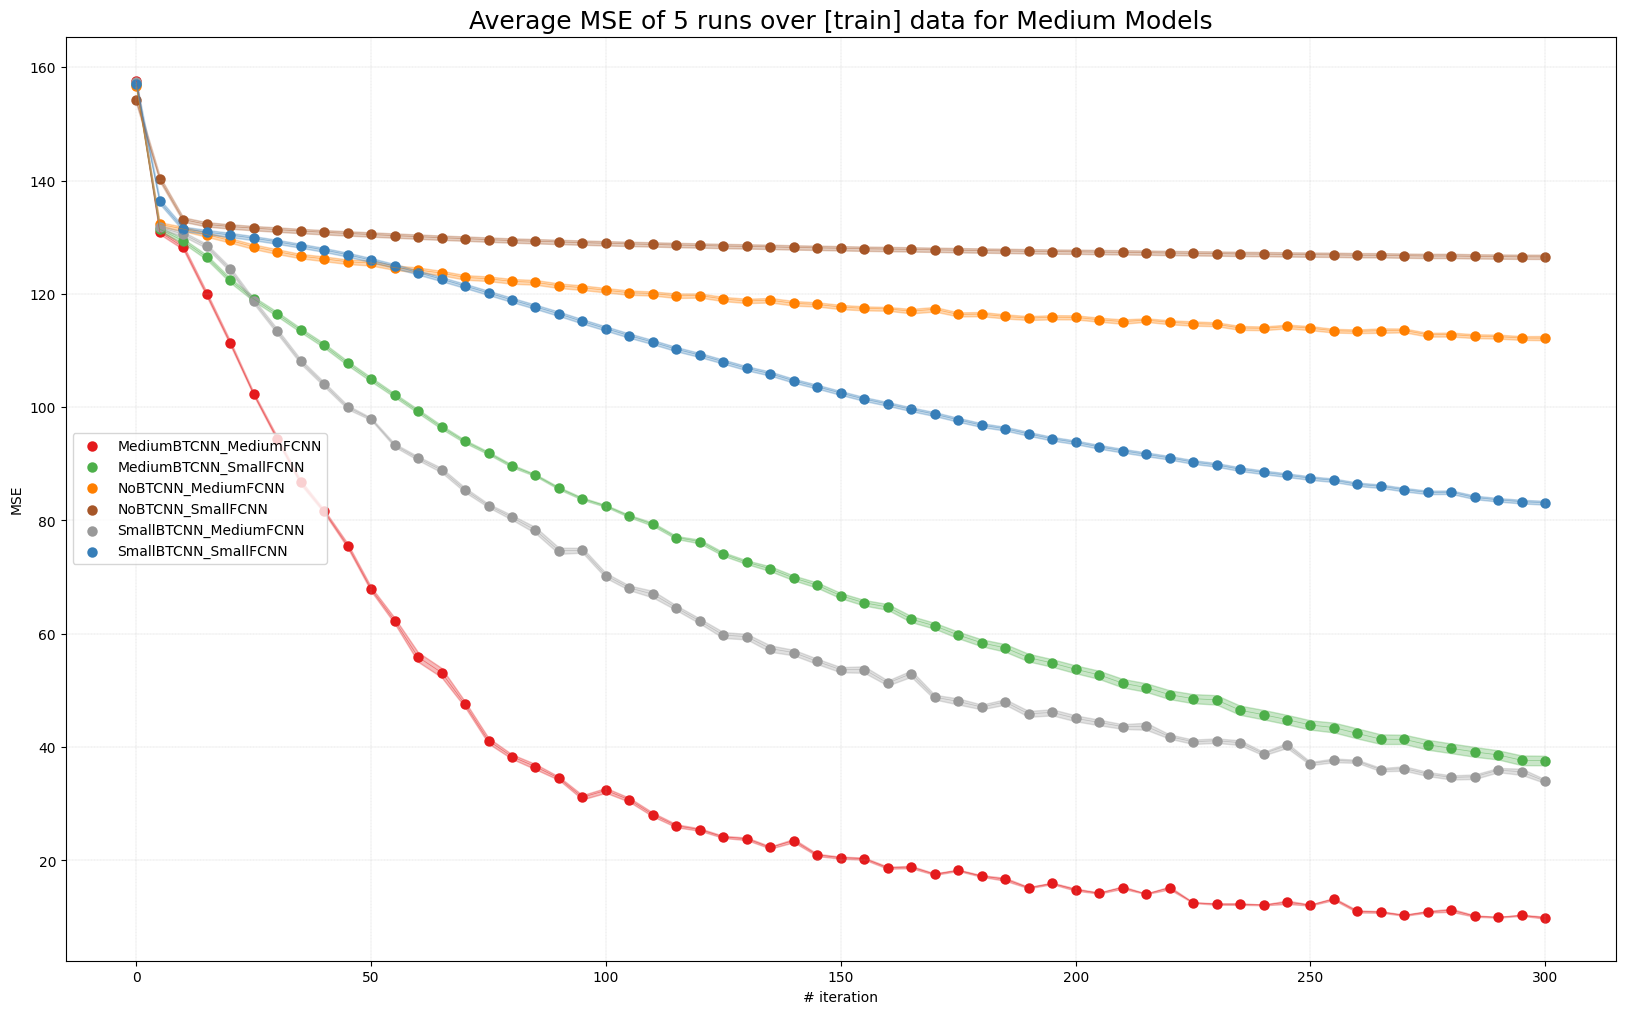

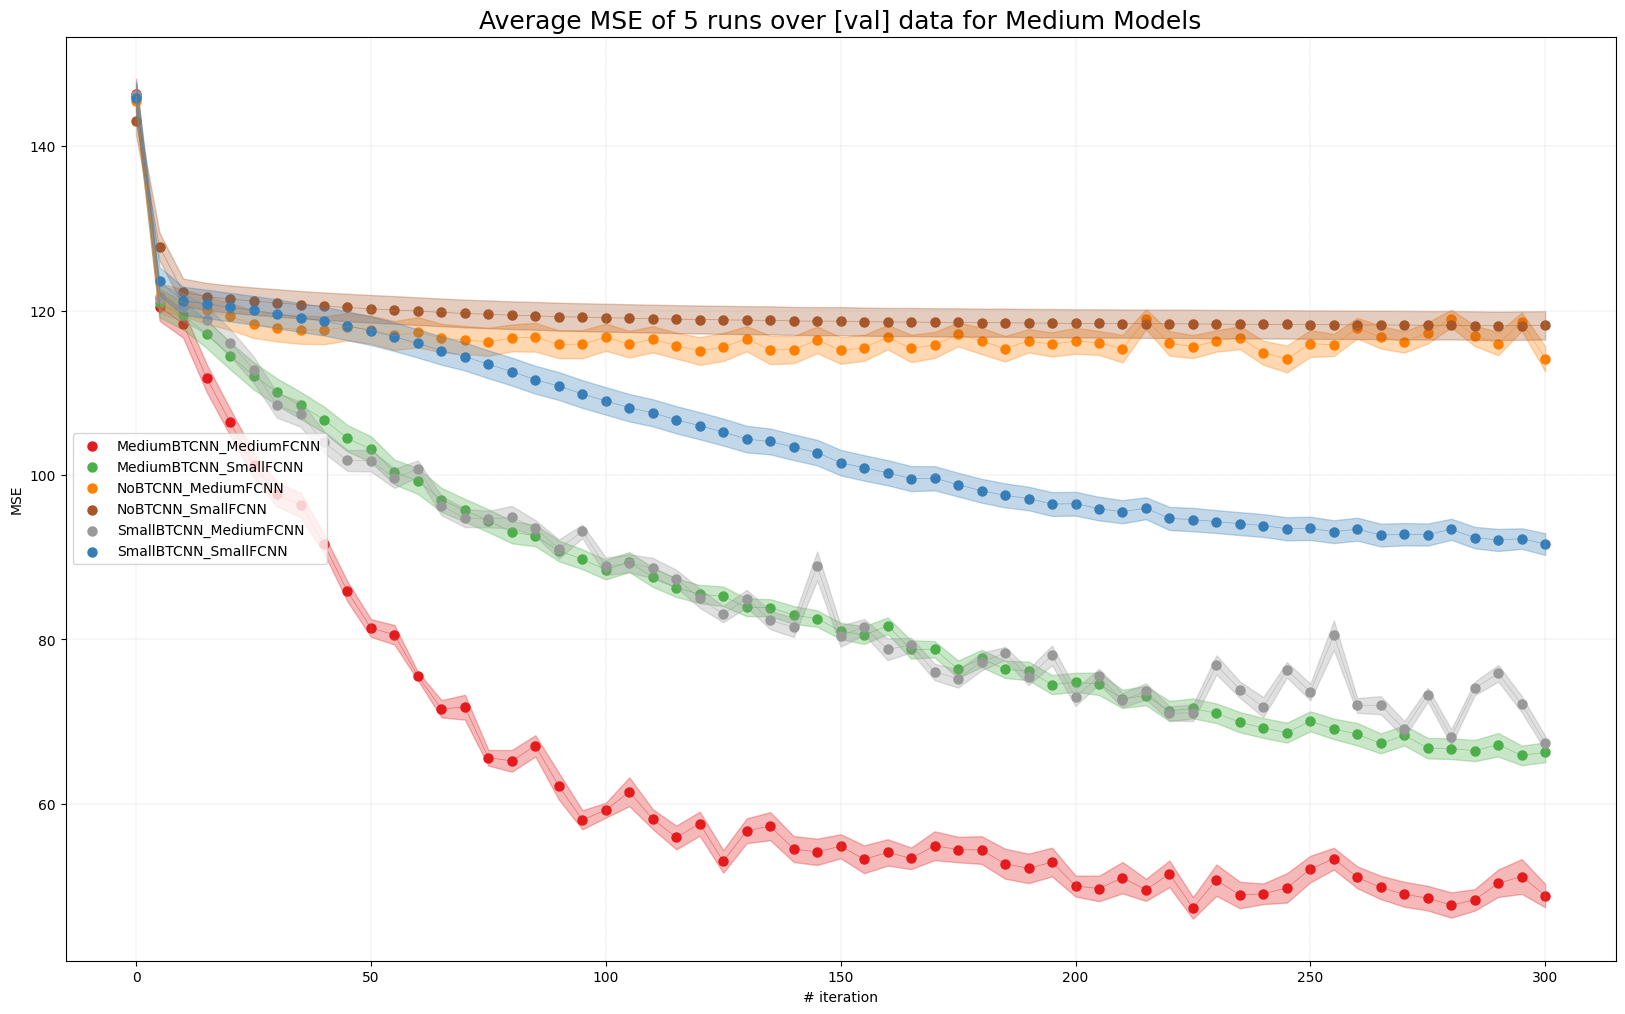

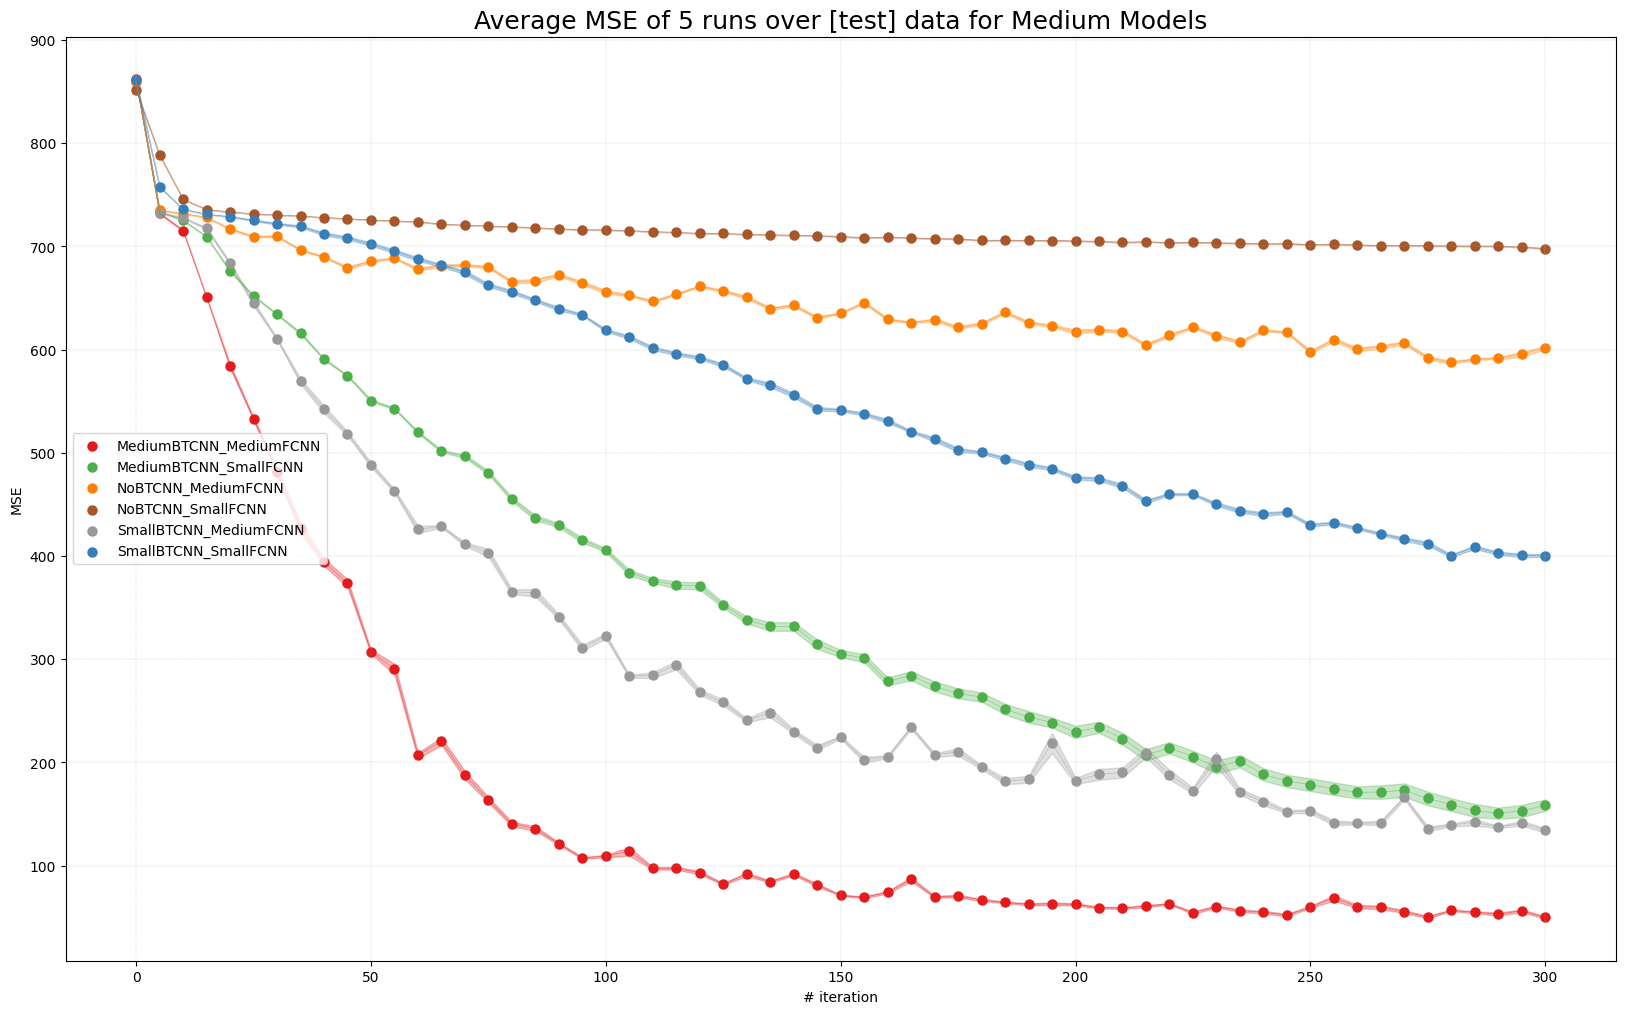

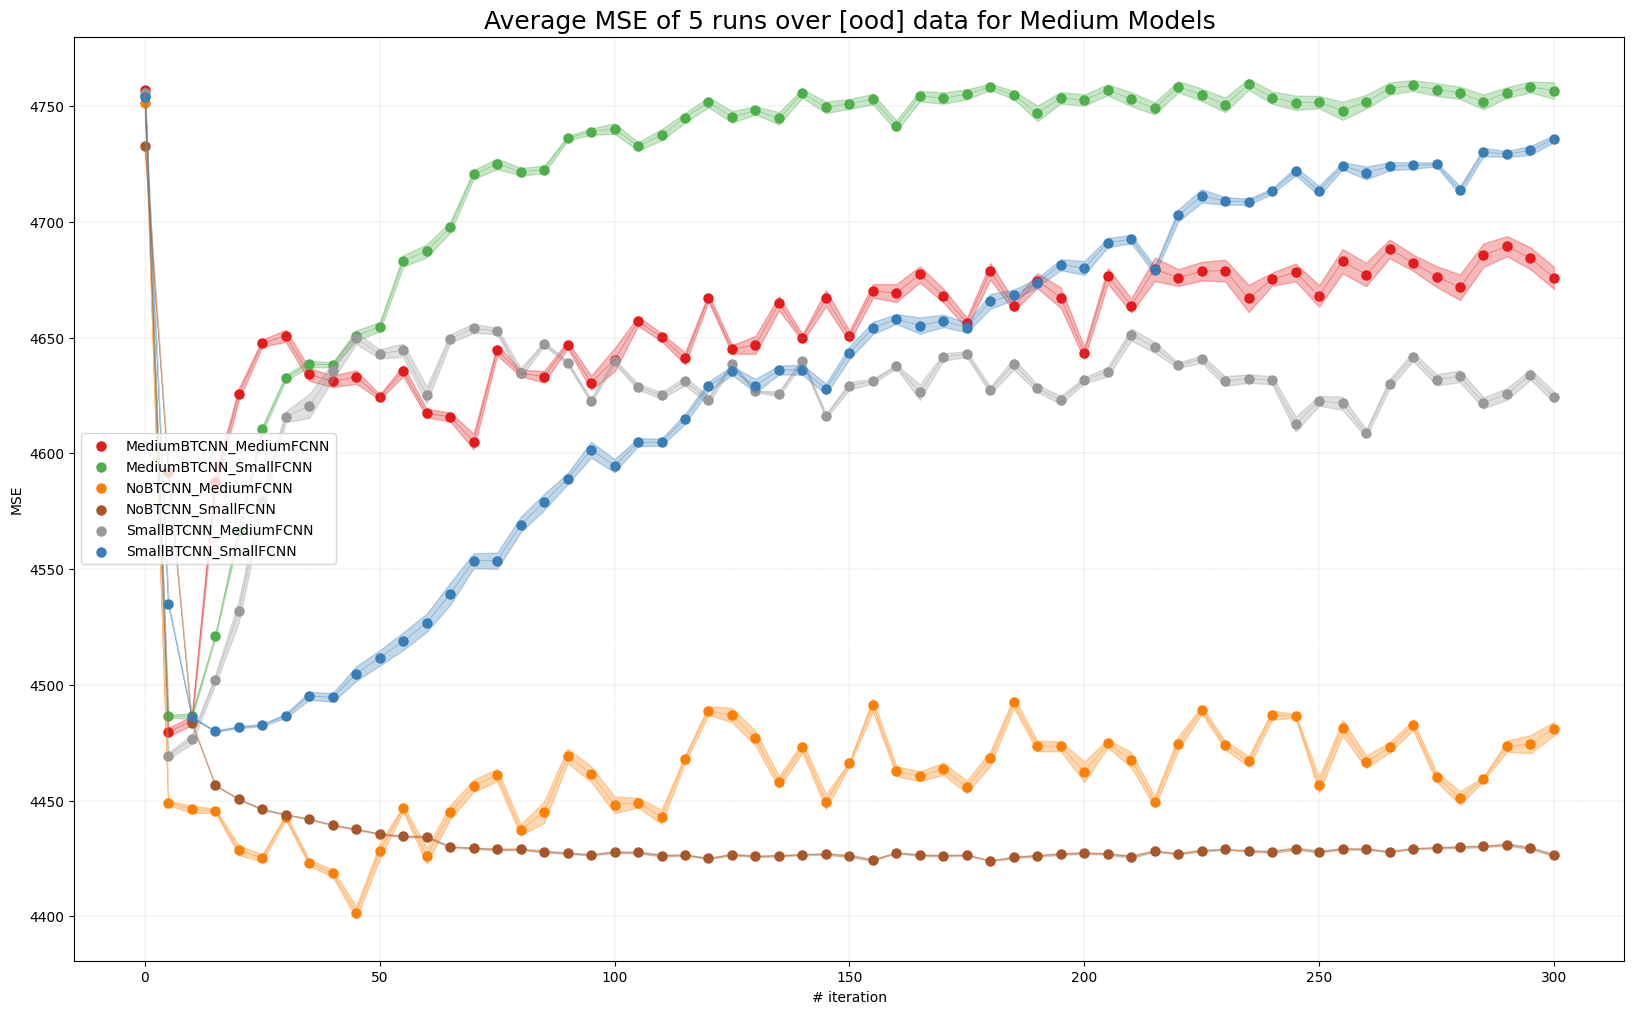

In [9]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/medium_models/{loss_type}.json", "r") as f:
        clearml_data = load(f)
    plot_mean_and_std(clearml_data, f"Average MSE of 5 runs over [{loss_type}] data for Medium Models", logscale=False, std_factor=.1, start_point=0)

So, `BinaryTreeConvolution` is really helpful layer

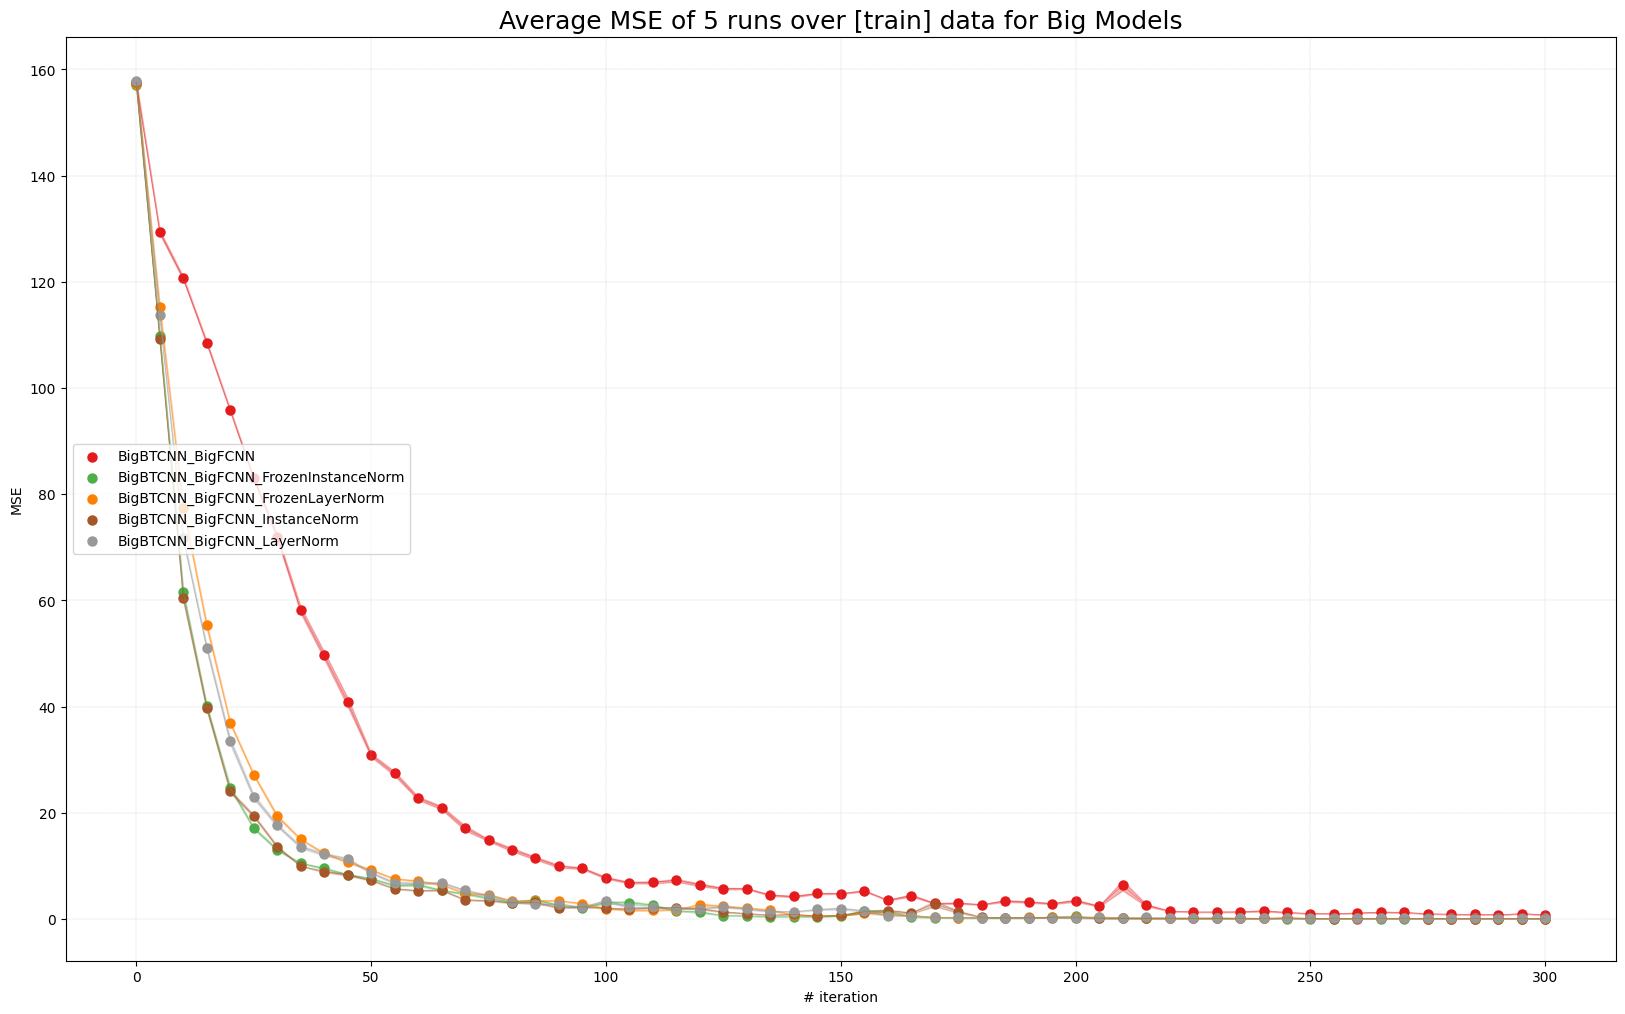

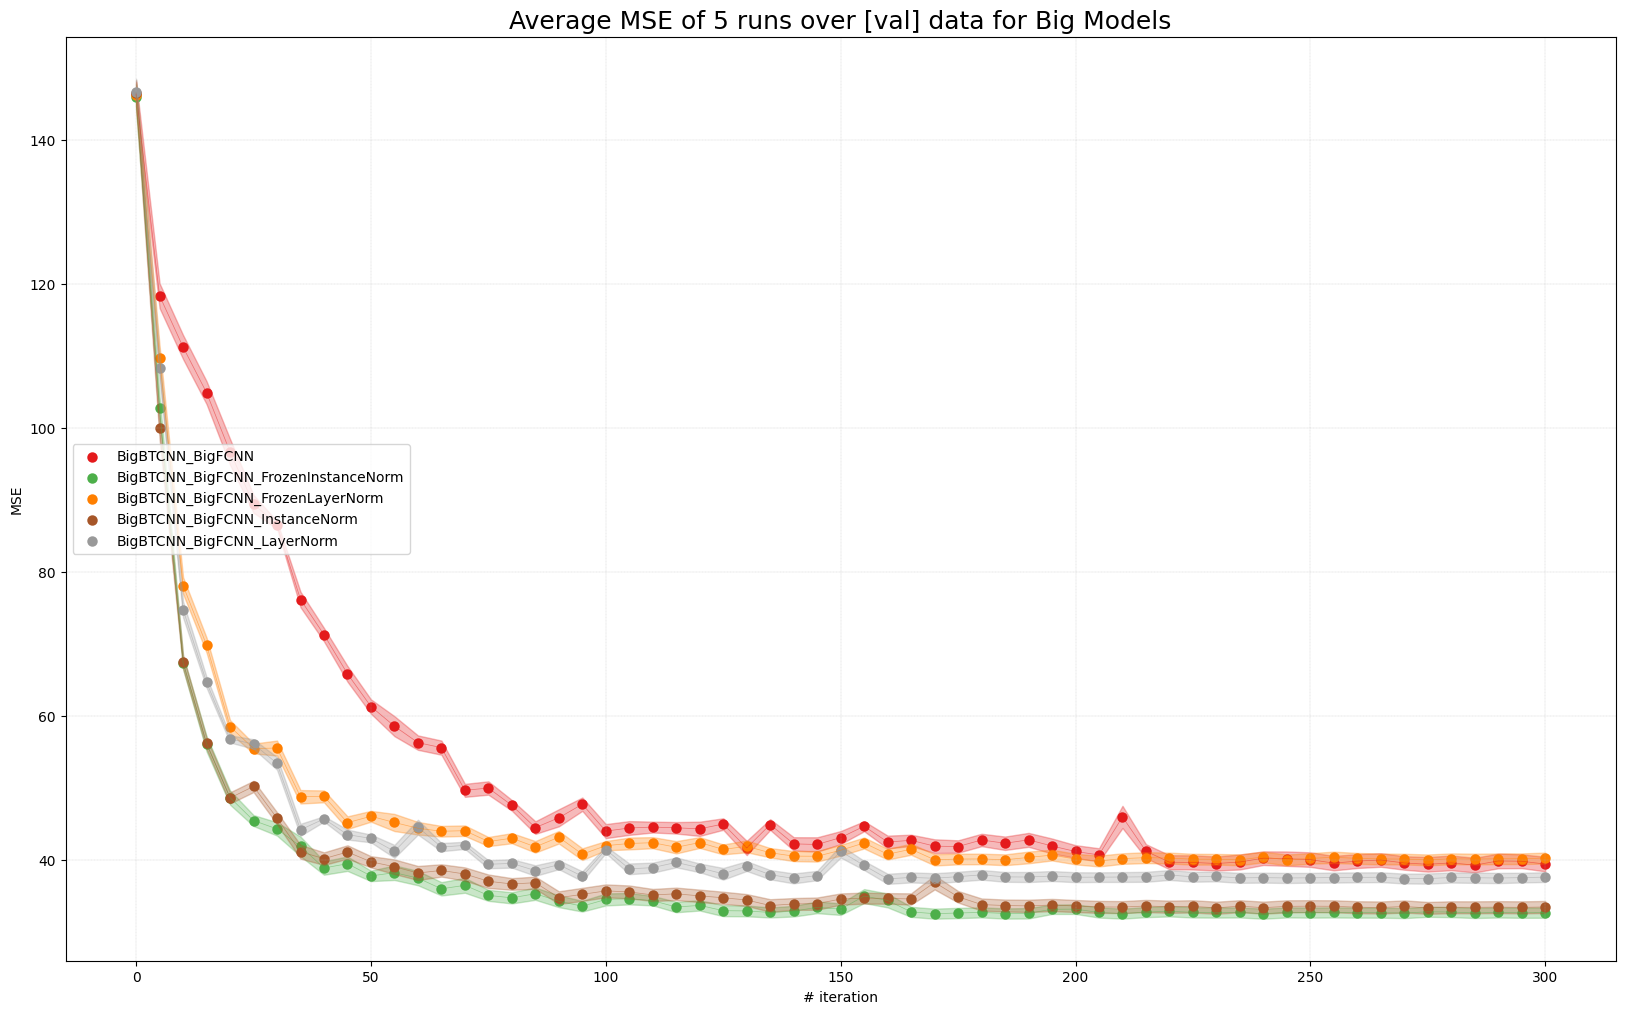

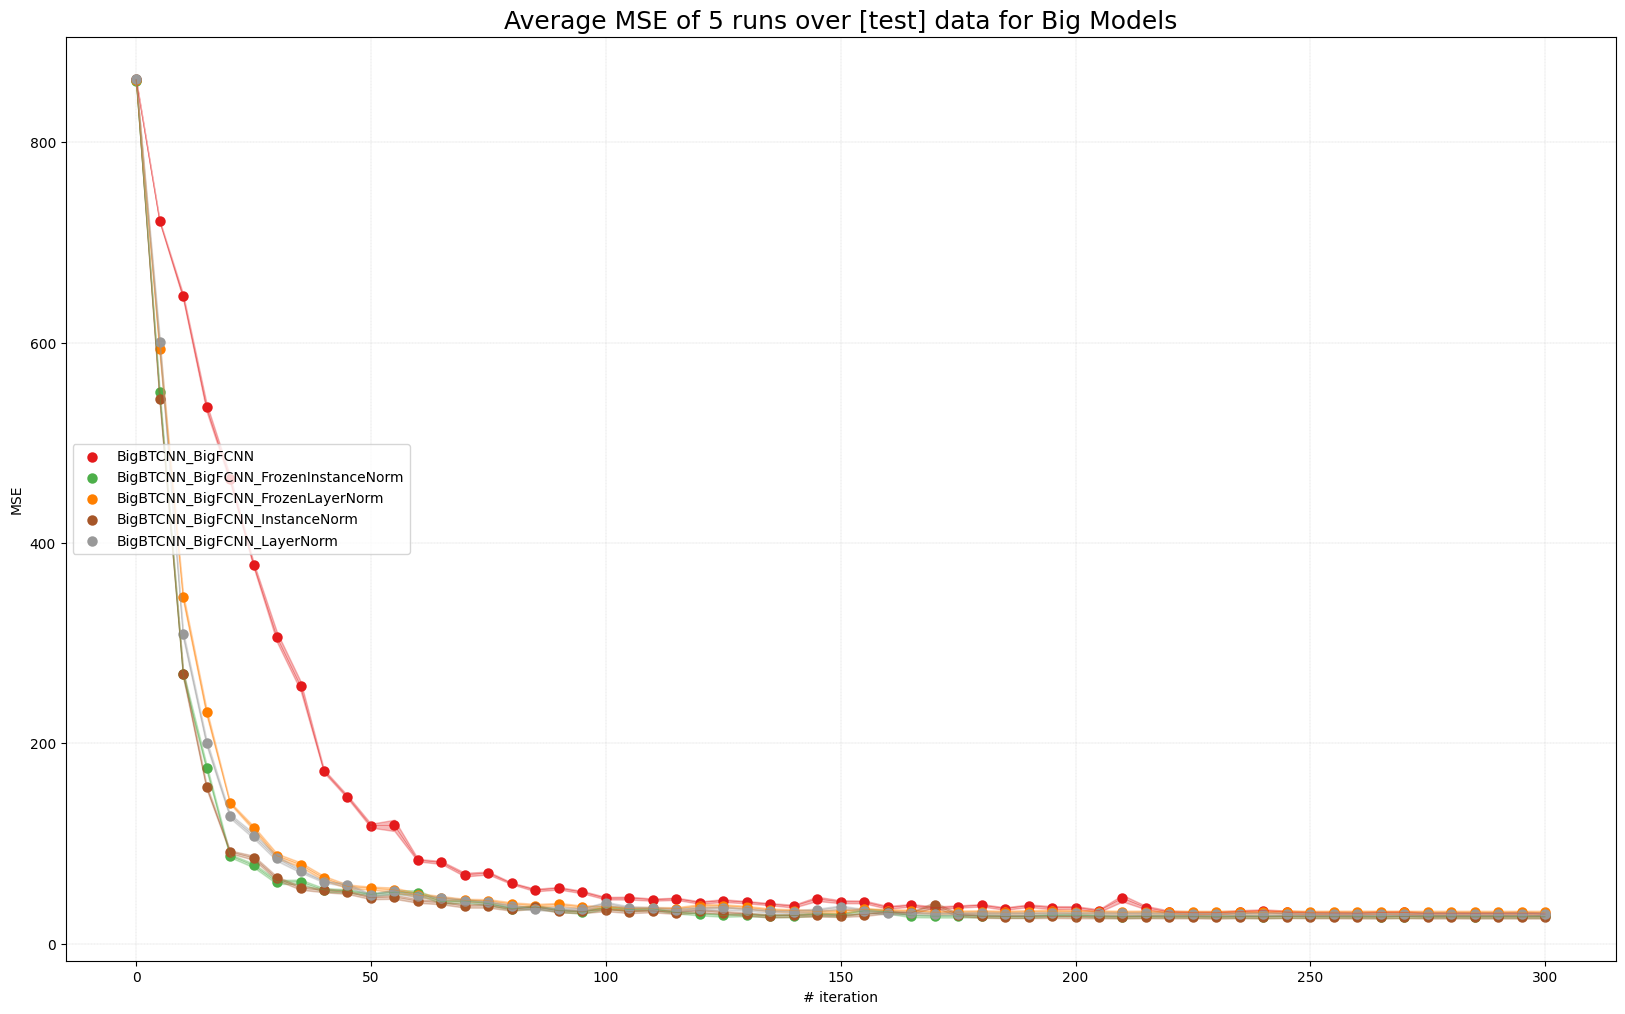

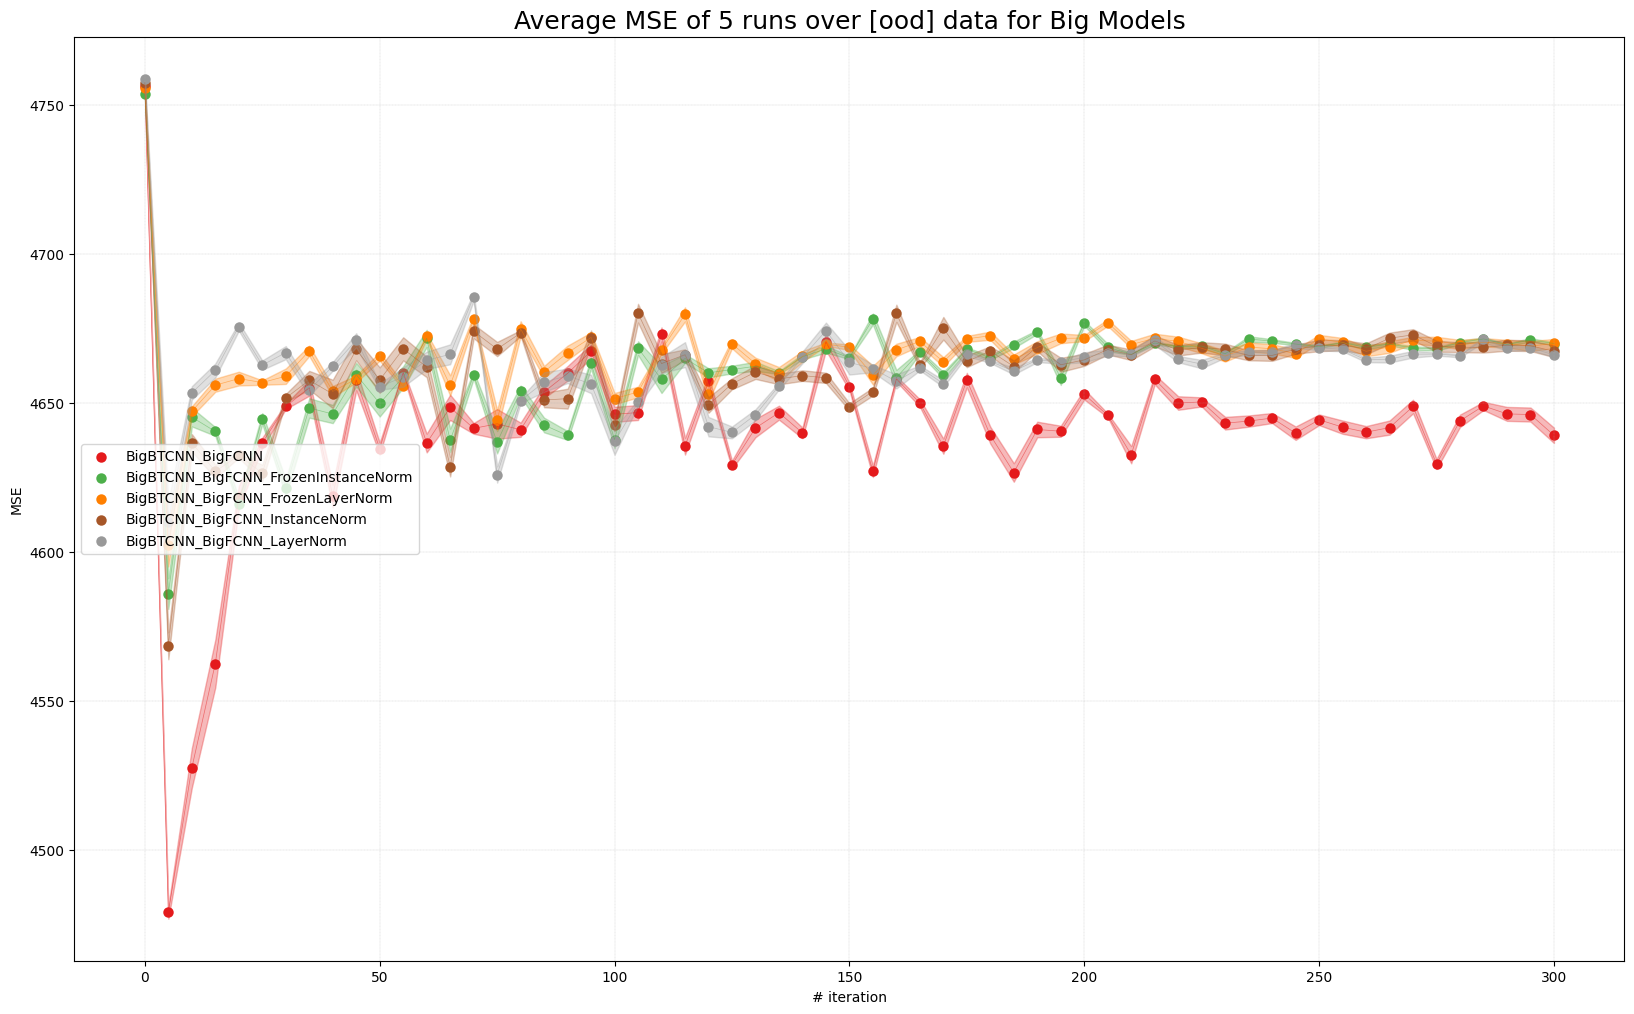

In [10]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/big_models/{loss_type}.json", "r") as f:
        clearml_data = load(f)
    plot_mean_and_std(clearml_data, f"Average MSE of 5 runs over [{loss_type}] data for Big Models", logscale=False, std_factor=.1, start_point=0)

It is worth noting that there **is no an "outperformance"** - the difference is of the order of `10-20%`, and the average curves already overlap by an interval of $\pm \sigma$. \
Also, depending on the split, `test` loss reaches up to 10 values. The reason of that will be studied in `analysing.ipynb`.

# **[additional]** Runs on noised data

Here we investigate the role of operation channels and statistics in vertex embedding. The goal is to understand whether tree structure alone or statistics alone is sufficient to predict time with equal accuracy.

In [28]:
def add_noise_to_vertices(v, channels, generator):
    noise = torch.rand(v.shape, device=v.device, generator=generator)
    res = v.clone()
    res[:,channels] = noise[:,channels]
    return res

In [29]:
class NoisedWeightedBinaryTreeDataset(WeightedBinaryTreeDataset):
    def __init__(
        self,
        list_vertices: "List[Tensor]",
        list_edges: "List[Tensor]",
        list_time: "List[Tensor]",
        device: "torch.device",
        noised_channels: "List[int]",  
        generator: "torch.Generator",
    ):
        super().__init__(list_vertices, list_edges, list_time, device)
        
        self.noised_channels = noised_channels
        for i, v in enumerate(self.list_vertices):
            self.list_vertices[i] = add_noise_to_vertices(v, channels=self.noised_channels, generator=generator)

In [30]:
def generate_noised_dataloaders(n, noised_channels):
    res = []
    for seed in range(42, 42+n):
        generator = torch.Generator(device=DEVICE).manual_seed(seed)
        noised_trainval_dataset = NoisedWeightedBinaryTreeDataset(job_list_vertices, job_list_edges, job_list_time, DEVICE, noised_channels, generator)
        noised_test_dataset = NoisedWeightedBinaryTreeDataset(id_sq_list_vertices, id_sq_list_edges, id_sq_list_time, DEVICE, noised_channels, generator)
        noised_ood_dataset = NoisedWeightedBinaryTreeDataset(ood_sq_list_vertices, ood_sq_list_edges, ood_sq_list_time, DEVICE, noised_channels, generator)
    
        generator = torch.Generator().manual_seed(seed)
        noised_train_dataset, noised_val_dataset = torch.utils.data.dataset.random_split(noised_trainval_dataset, [0.8, 0.2], generator=generator)

        train_dataloader, val_dataloader, test_dataloader, ood_dataloader = [
            DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=True,
                collate_fn=lambda el: weighted_binary_tree_collate(el, max_length),
                drop_last=False
            )
            for dataset in [noised_train_dataset, noised_val_dataset, noised_test_dataset, noised_ood_dataset]
        ]        
        yield (train_dataloader, val_dataloader, test_dataloader, ood_dataloader)

In [ ]:
task = Task.init(project_name="hero", task_name="Noised data")
assert task is not None

In [32]:
epochs = 150
metadata = {
    "data": "noised_weighted_dataset",
    "lr": lr,
    "batch_size": batch_size
}
n_runs = 10

In [ ]:
for noised_channels, noise_description in [
    (range(len(ALL_FEATURES)), "all"), 
    (range(len(ALL_FEATURES)-2), "ops"), 
    (range(len(ALL_FEATURES)-2, len(ALL_FEATURES)), "stats"),
    ]:
    for run, (train_dataloader, val_dataloader, test_dataloader, ood_dataloader) in enumerate(generate_noised_dataloaders(n_runs, noised_channels), start=1):
        model = BinaryTreeRegressor(big_btcnn_and_instance_norm(), big_fcnn(), "BigBTCNN_BigFCNN_InstanceNorm")
        model.name = "[" + noise_description + "] " + model.name + "_" + str(run)
        model.btcnn.to(DEVICE)
        model.fcnn.to(DEVICE)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        set_seed(2024)
        weighted_train_loop(
            model=model,
            optimizer=optimizer,
            criterion=nn.MSELoss(reduction="none"),
            scheduler=scheduler,
            train_dataloader=train_dataloader,
            num_epochs=epochs,
            clearml_task=task,
            metadata=metadata,
            ckpt_period=epochs,
            eval_period=5,
            val_dataloader=val_dataloader,
            test_dataloader=test_dataloader,
            ood_dataloader=ood_dataloader,
            path_to_save=f"{EXPERIMENT_PATH}/models/{model.name}.pth",
        )

task.close()

#### Loss Curves

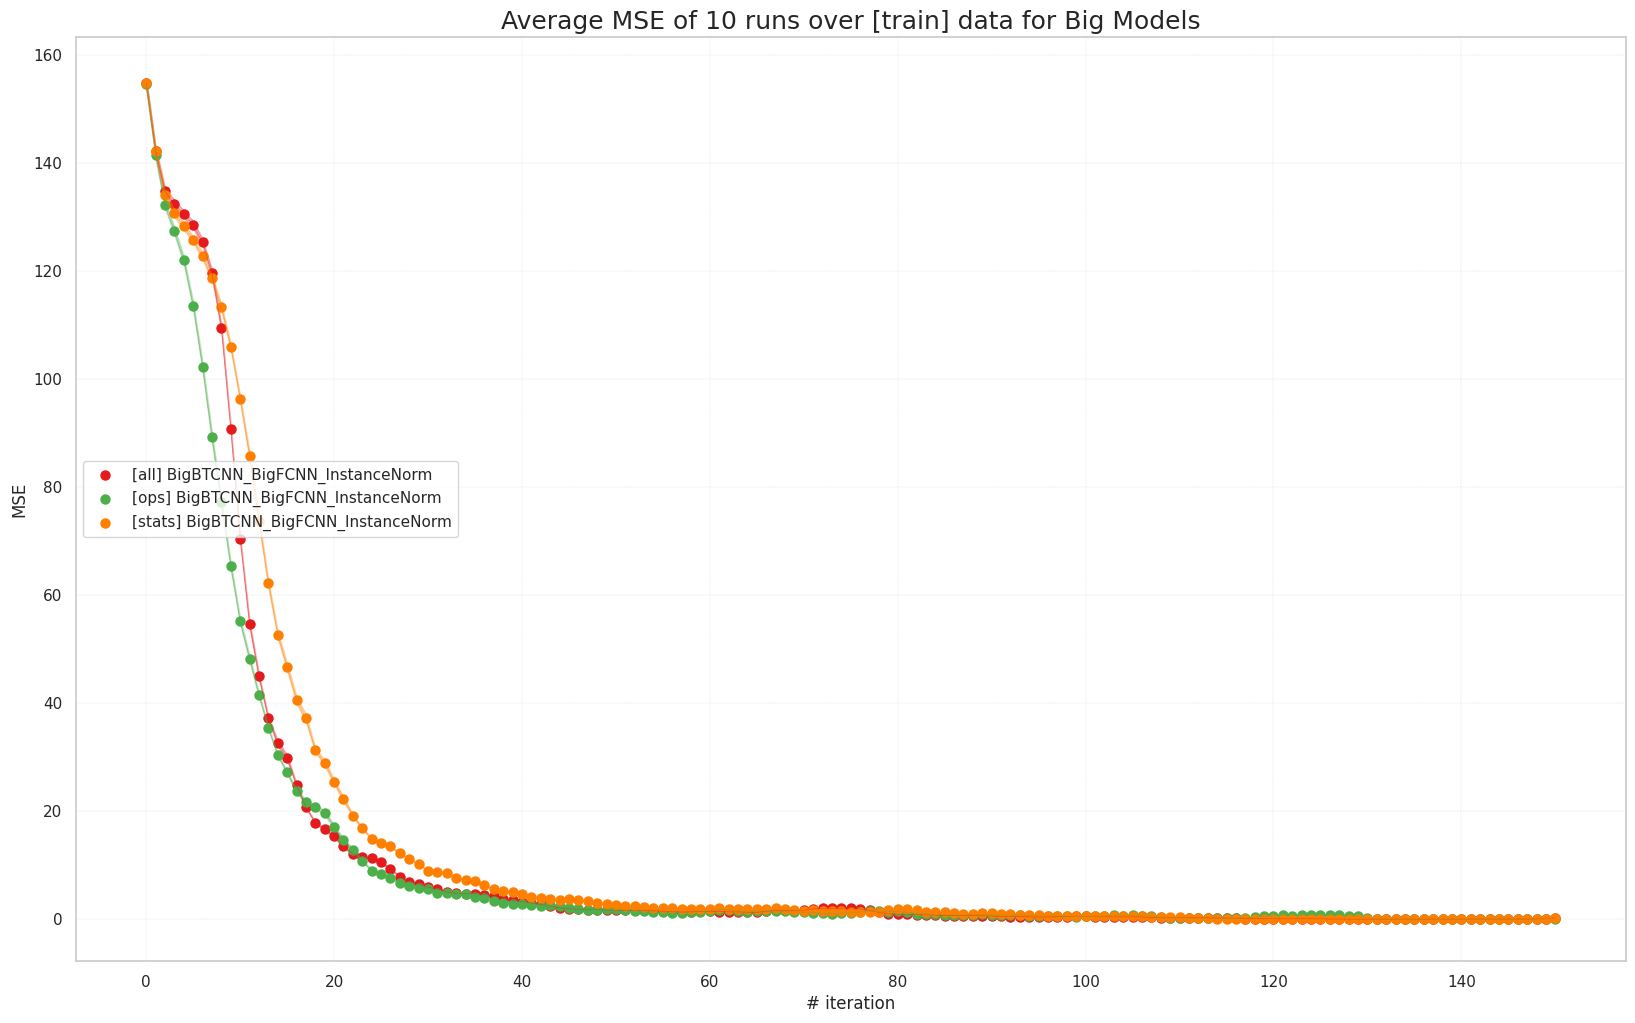

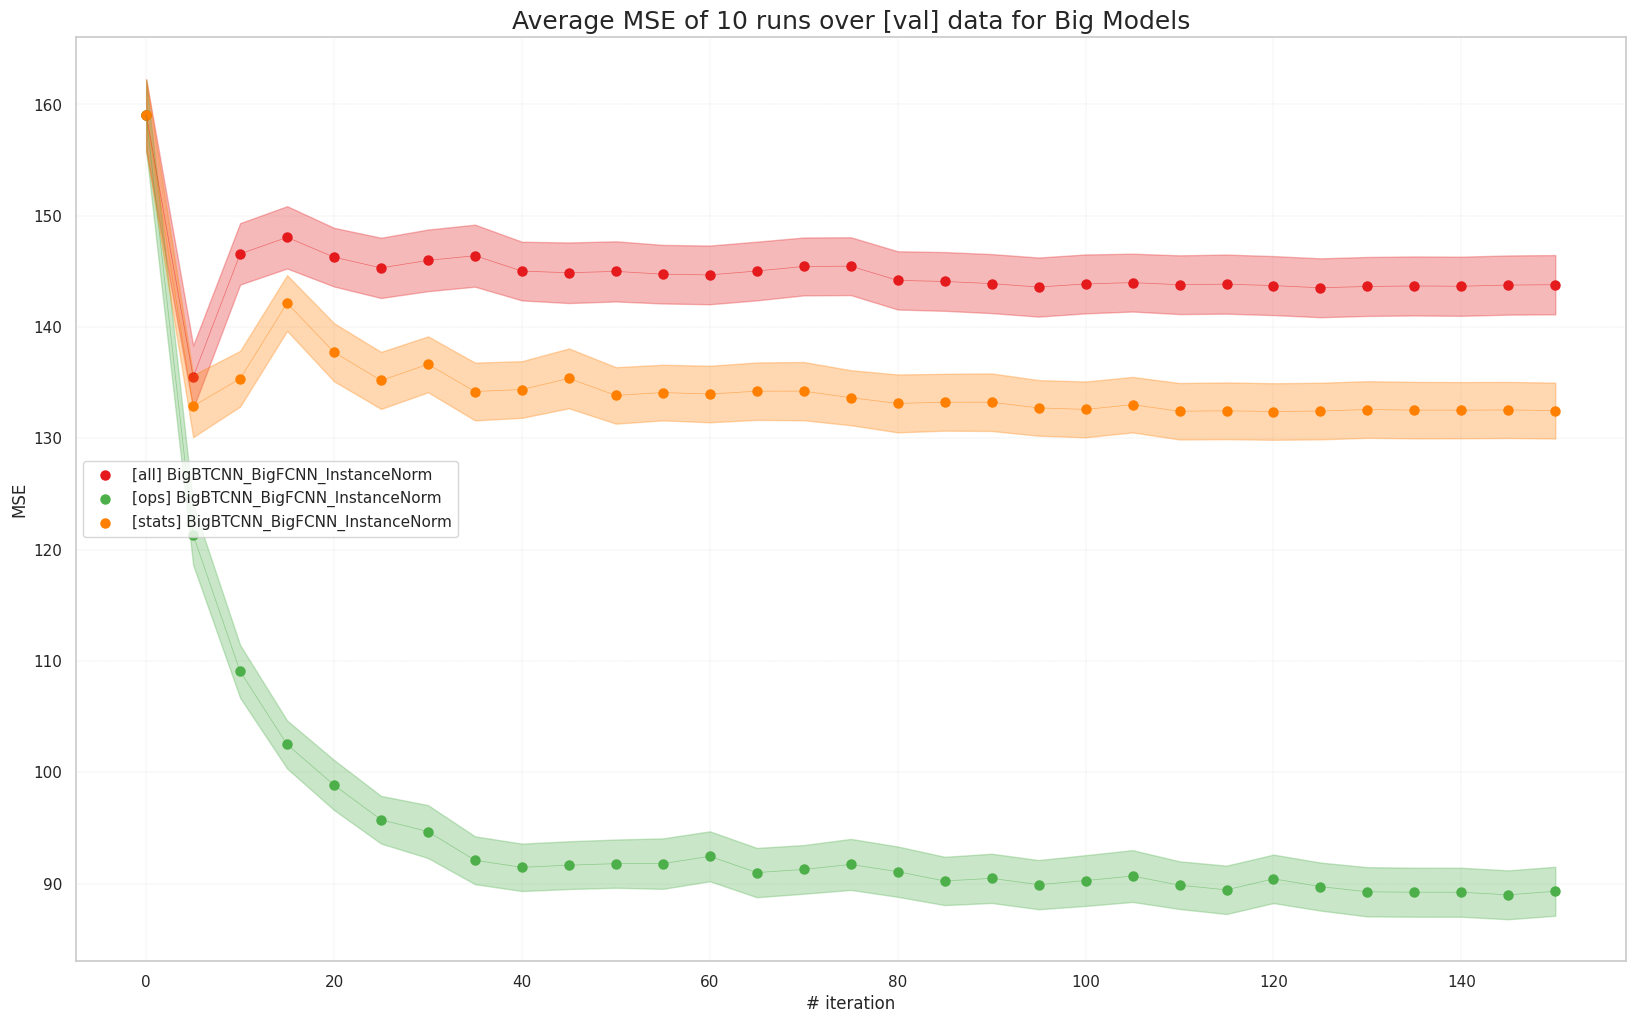

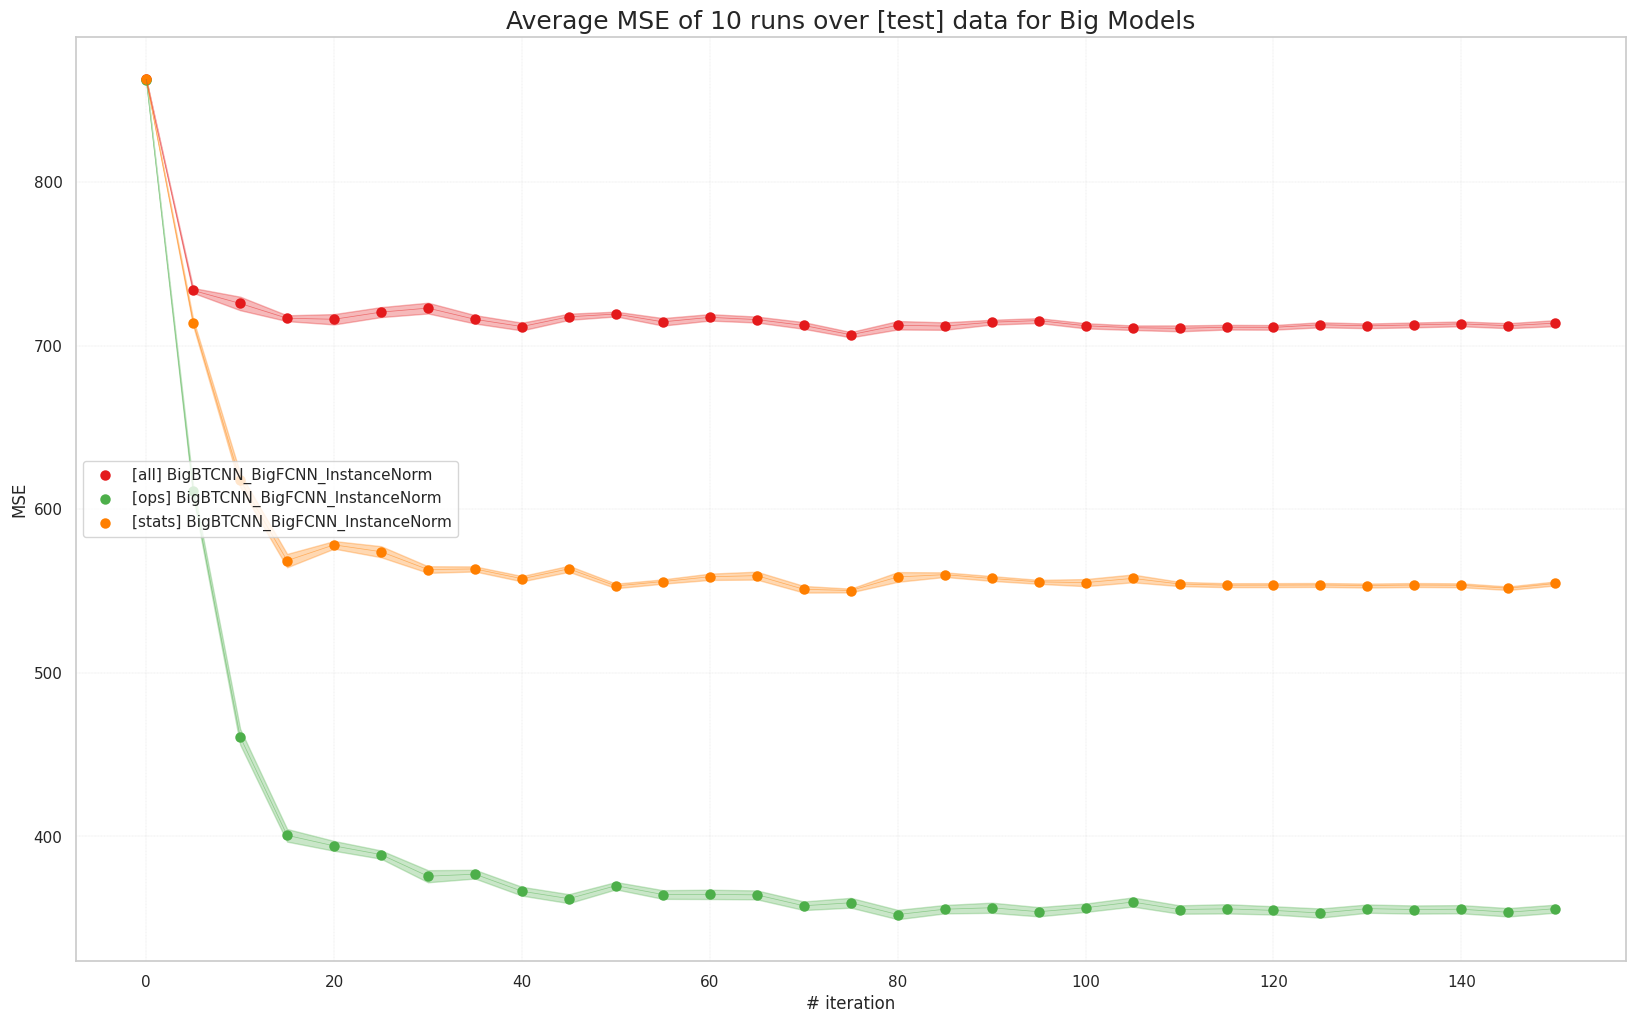

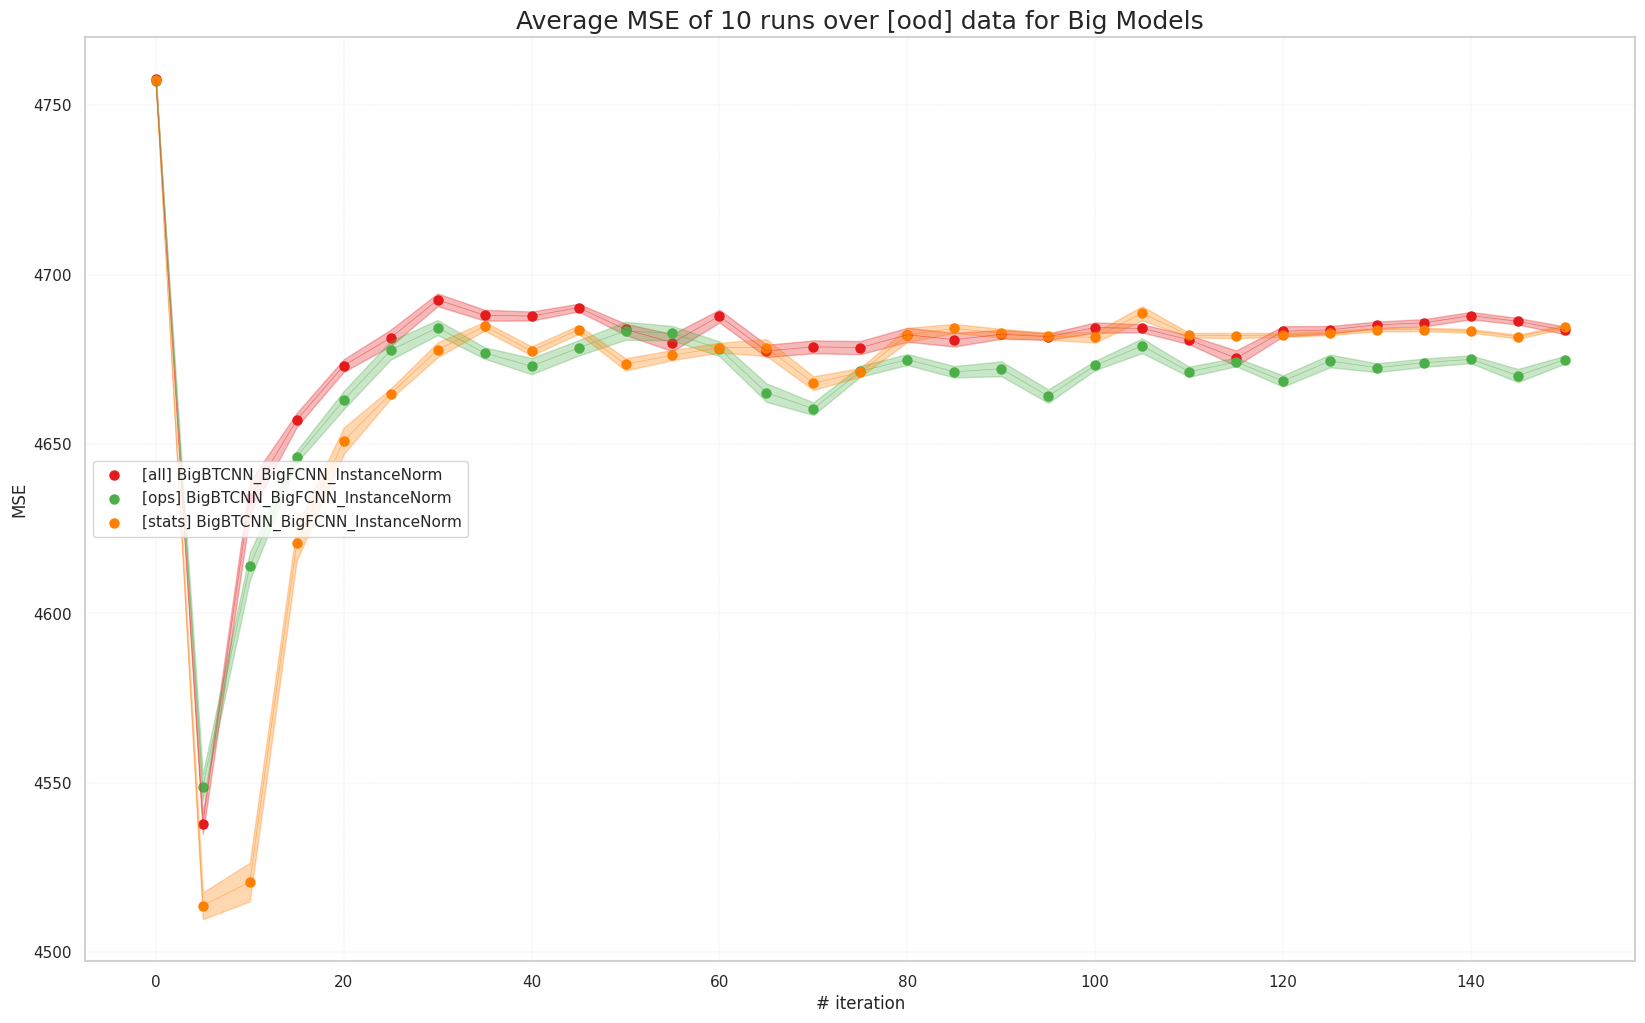

In [85]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/noised_data/{loss_type}.json", "r") as f:
        clearml_data = load(f)
    plot_mean_and_std(clearml_data, f"Average MSE of 10 runs over [{loss_type}] data for Big Models", logscale=False, std_factor=.1, start_point=0)

As expected - there is no generalisation when training on full noise, the network only memorises examples. \
When the statistical channels are noisy, it becomes much more difficult for the NN to predict the execution time. Not surprisingly, because these statistics are estimates of the size of the data being processed, derived from the cardinality model. They take into account the statistics in the database and greatly simplify the modelling of runtime dependence. In a sense, the NN only trains the correct cost `GUQ`s.\
Note, that if both operations and statistics are available, then NN model can learn **contextual** dependency between plan and time.

# Summary

The working hypothesis is that the trained NN actually plays the role of a complex (with contextual by operations dependency) cost model, where a time scale is used instead of an abstract cost scale. In this case, the question arises:
<center><i>"Is the quality of the trained model on validation / test set better than the quality of cost model?"</i></center>
We'll check this in the next experiment.